# Binary star evolution and binary black holes

All the relevant information for the project are to be found in the pdf document present in the repo.
Note that you are assigned to project 1 (as the title said).

## Datasets 

Datasets are stored on Google Drive (link and description in the pdf document)

### Contacts

* Michela Mapelli <michela.mapelli@unipd.it>


In [120]:
import pandas as pd
import numpy as np
import string
import glob
import os
import seaborn as sns
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy import linalg as la
from IPython.display import display

In [67]:
# personalized computer settings

hname = os.getlogin()
path = ''

if hname=='paolozinesi': path = '/Users/paolozinesi/Downloads/Project_LCP_A/stable_MT_vs_CE/'
if hname=='tommaso': path = "/Users/tommaso/Desktop/MagistraleI/TheFormationOfBinaryBlackHoles_data/lab_data/stable_MT_vs_CE/"
if hname=='Nicola': path = "/Users/Nicola/data/TheFormationOfBinaryBlackHoles_data/stable_MT_vs_CE/"
if hname=='ilazza': path = "/home/ilazza/Documenti/UNIPD/TheFormationOfBinaryBlackHoles/stable_MT_vs_CE/"

In [68]:
alpha_values = [0.5, 1, 3, 5]
met_values = [0.02, 0.002, 0.0002, 0.004, 0.0004, 0.006, 0.008, 0.012, 0.0012, 0.016, 0.0016]

frame = pd.DataFrame(data=None, columns=['col.0:ID','col.1:m1ZAMS/Msun', 'col.2:m2ZAMS/Msun', 'col.3:m1rem/Msun','col.4:m2rem/Msun',  'col.6:delay_time/Myr', 'col.7:sma/Rsun', 'col.8:ecc', 'col.21:CE'])

for alpha in alpha_values:
    for met in met_values:
        for name in glob.glob(path+f'A{alpha}/MTCE_BBHs_{met}*'):
            df = pd.read_csv(name, skiprows=2, header=0, sep=' ')
            df = df.loc[:,['col.0:ID','col.1:m1ZAMS/Msun', 'col.2:m2ZAMS/Msun','col.3:m1rem/Msun','col.4:m2rem/Msun',  'col.6:delay_time/Myr', 'col.7:sma/Rsun', 'col.8:ecc', 'col.21:CE']]
            met_array = np.ones((df.shape[0], 1))*met
            alpha_array = np.ones((df.shape[0],1))*alpha
            df['metallicity'] = met_array
            df['alpha'] = alpha_array
            
            frame = pd.concat([frame, df], axis=0, ignore_index=True)


In [69]:
frame.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha
0,0_6942,50.9151,50.8356,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5
1,0_80347,57.0253,56.9464,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5
2,0_158611,91.0594,90.7083,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5
3,0_211410,117.9396,57.6917,19.3984,11.2422,7905.6343,11229.0000,0.999640,False,0.02,0.5
4,0_213101,40.2965,40.2439,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5


In [70]:
#Creating the a dataframe with common envelopes and one with mass transfer
frame_true = frame[(frame['col.21:CE'] == True)] 
frame_true = frame_true.reset_index(drop=True)
frame_false = frame[(frame['col.21:CE'] == False)] 
frame_false = frame_false.reset_index(drop=True)

In [71]:
frame_true.head()



,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha
0,0_6942,50.9151,50.8356,4.8001,4.7478,2233.6292,7.9524,0.273150,True,0.02,0.5
1,0_80347,57.0253,56.9464,5.5849,5.5325,1076.5703,9.0222,0.508320,True,0.02,0.5
2,0_158611,91.0594,90.7083,8.3787,8.2624,6810.4365,14.9810,0.072798,True,0.02,0.5
3,0_213101,40.2965,40.2439,3.1045,3.0769,8703.5479,13.7630,0.705290,True,0.02,0.5
4,0_261642,62.6781,58.8130,7.5024,5.9658,2895.4182,10.4610,0.163210,True,0.02,0.5


In [72]:
frame_false.head()

,col.0:ID,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha
0,0_211410,117.9396,57.6917,19.3984,11.2422,7905.6343,11229.000,0.999640,False,0.020,0.5
1,1_3370919,76.2366,38.3205,10.0905,8.1532,5914.8696,5378.200,0.999510,False,0.020,0.5
2,1_3601930,123.0264,39.9761,18.0234,7.6028,9398.3252,3408.700,0.998740,False,0.020,0.5
3,3_2982857,132.6673,30.7234,20.7397,5.6742,3331.2690,3755.500,0.999260,False,0.020,0.5
4,0_526,75.1587,33.6683,26.1035,25.6875,12982.4980,41.214,0.009654,False,0.002,0.5


In [8]:
#frame_graph = frame.drop(columns=['col.0:ID'], axis=1)
#sns.pairplot(frame, hue = 'col.21:CE', palette='Set2')

In [9]:
#frame_graph.head()

In [10]:



#frame_graph = frame.drop(columns=['col.0:ID', 'metallicity', 'alpha'], axis=1)
#sns.pairplot(frame_graph, hue = 'col.21:CE', palette='Set2')
                    

**!!! WARNING, il blocco sotto ("ML algorithms") ci mette un paio d'ore per runnare**

## ML algorithms

In [73]:
# create training and test set
m_train = 20000
m_test = 1000

frame_sample = pd.concat([frame_true.sample(n=int(0.5*(m_train+m_test))),
                          frame_false.sample(n=int(0.5*(m_train+m_test)))], ignore_index=True)
frame_train = frame_sample.iloc[:m_train]
frame_test = frame_sample.iloc[-m_test:]

# convert dataframe into a numpy array
X_train = frame_train.drop(labels=["col.0:ID","col.21:CE"], axis=1).values
Y_train = frame_train["col.21:CE"].apply(lambda x: np.sum(x)).values
X_test = frame_test.drop(labels=["col.0:ID","col.21:CE"], axis=1).values
Y_test = frame_test["col.21:CE"].apply(lambda x: np.sum(x)).values

### PCA

In [134]:
# DATA NORMALIZATION
# standardize the input matrix
from sklearn import preprocessing
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_train) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_train_ = scaler.transform(X_train)
print ("\nMean of the training input data:", X_train_.mean(axis=0))
print ("Std of the training input data:", X_train_.std(axis=0))
X_test_ = scaler.transform(X_test) # use the same transformation on test data
print ("\nMean of the test input data:", X_test_.mean(axis=0))
print ("Std of the test input data:", X_test_.std(axis=0))

# PCA
data_PCA = X_train_.T
# eigenvectors and eigenvalues using SVD
U, spectrum, Vt = la.svd(data_PCA)
V = U                          # eigenvectors matrix
l = spectrum**2/(m_train-1)    # eigenvalues
np.set_printoptions(precision=3)
print('\nEigenvalues: \n', l)
# print('Eigenvectors:\n', V_svd)

ncomp = 7
variability_PC = np.sum(l[:ncomp])/np.sum(l)
print('\nPercent of the total variability explained by the %.0f principal components: %.5f' %(ncomp, variability_PC))


Mean of the training input data: [ 0. -0.  0. -0.  0. -0.  0. -0. -0.]
Std of the training input data: [1. 1. 1. 1. 1. 1. 1. 1. 1.]

Mean of the test input data: [ 0.616  0.111  0.638  0.47   0.333  0.044 -0.4    0.046  0.013]
Std of the test input data: [0.883 0.845 0.782 0.815 1.087 0.088 0.127 0.965 1.035]

Eigenvalues: 
 [3.887 1.304 1.181 0.956 0.702 0.626 0.267 0.058 0.018]

Percent of the total variability explained by the 7 principal components: 0.99149


,0,1,2,3,4,5,6,col.21:CE
0,-4.08778,-0.794848,0.897501,-1.25662,-1.355836,0.071367,-1.346727,True
1,3.888333,-0.128275,-1.123618,-1.854385,-2.229569,-0.286167,0.575408,True
2,-0.038923,-0.234845,1.078324,0.203582,0.293739,-0.116152,-0.41227,True
3,1.660765,-0.221855,1.615609,0.393822,0.318913,-0.036651,-0.637471,True
4,-3.817164,-0.139655,0.235963,-0.753041,-1.018339,0.431546,-0.87118,True


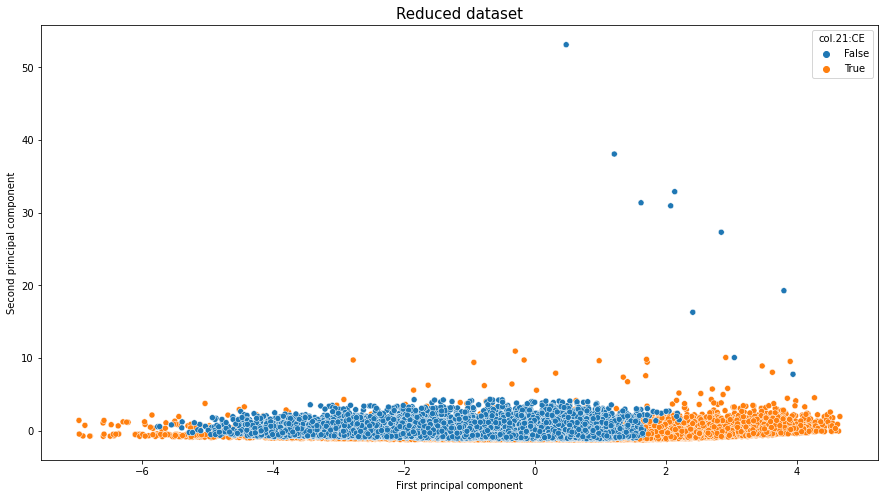

In [138]:
# Data in the PCA basis
data_ = np.dot(V.T, data_PCA)

# Reduce the dimensionality of the dataset 
data_reduced = data_[:ncomp,:] 

X_train_PCA = data_reduced.T
X_test_PCA = np.dot(V.T, X_test_.T)[:ncomp,:].T
# print(X_train_PCA.shape)
# print(X_test_PCA.shape)

df = pd.DataFrame(np.column_stack((X_train_PCA, frame_train["col.21:CE"])))
df.rename(columns = {7:'col.21:CE'}, inplace=True)
display(df.head())

plt.figure(figsize=(15, 8))
sns.scatterplot(x=0, y=1, hue='col.21:CE', data=df)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Reduced dataset', fontsize=15)
plt.show()

#### Random Forest

In [12]:
RF_clf = RandomForestClassifier(max_depth=None)
RF_clf.fit(X_train, Y_train)

train_err = 1 - RF_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - RF_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

Training error = 0.000
Test error = 0.003


#### SVM

In [13]:
SVM_clf = sklearn.svm.SVC()
SVM_clf.fit(X_train, Y_train)

train_err = 1 - SVM_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - SVM_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

#### Neural Network

In [ ]:
NN_clf = MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive')
NN_clf.fit(X_train, Y_train)

train_err = 1 - NN_clf.score(X_train, Y_train)
print("Training error = %1.3f" % train_err)

test_err = 1 - NN_clf.score(X_test, Y_test)
print("Test error = %1.3f" % test_err)

Training error = 0.058
Test error = 0.015


In [11]:
frame_sample.head()
frame_sample_2 = frame_sample.drop(columns=['col.0:ID'])
frame_sample_2.head()

,col.1:m1ZAMS/Msun,col.2:m2ZAMS/Msun,col.3:m1rem/Msun,col.4:m2rem/Msun,col.6:delay_time/Myr,col.7:sma/Rsun,col.8:ecc,col.21:CE,metallicity,alpha
0,22.5659,16.4244,4.8738,7.5110,101.0276,4.1515,0.225360,True,0.0004,1.0
1,63.7183,53.9438,25.6346,31.7708,400.0737,18.4090,0.010127,True,0.0012,0.5
2,28.9483,16.3088,6.7171,8.9373,80.8664,4.6100,0.178680,True,0.0004,3.0
3,33.0213,18.2575,7.9469,10.3766,4607.1851,14.8940,0.184570,True,0.0016,3.0
4,44.3181,35.9921,15.4485,20.8249,35.2588,6.7091,0.013784,True,0.0016,0.5


## Plot

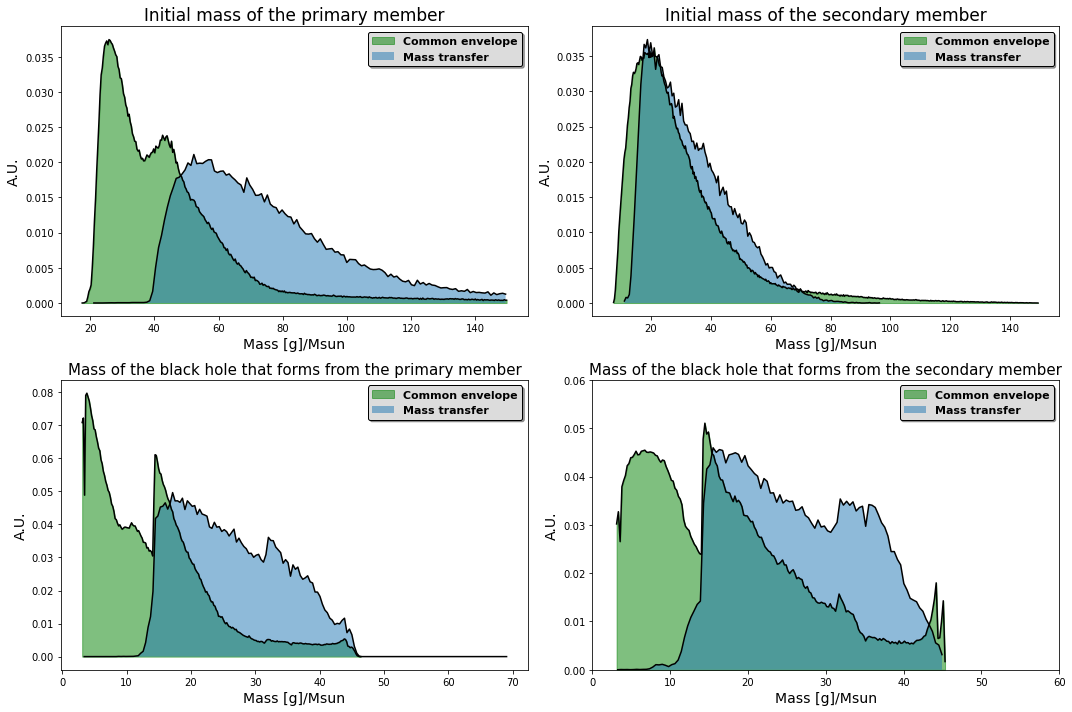

In [12]:
fig, ax = plt.subplots(nrows= 2, ncols=2, figsize=(15, 10))



#[0,0]  -   col.1:m1ZAMS/Msun - col.21:CE   - Initial mass of the primary member per Formation Process

entries_1_t, edges_1_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.1:m1ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_t = 0.5 * (edges_1_t[:-1] + edges_1_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_1_f, edges_1_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.1:m1ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_1_f = 0.5 * (edges_1_f[:-1] + edges_1_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0,0].plot(bin_centers_1_t, entries_1_t, color='black')
ax[0,0].fill_between(bin_centers_1_t, entries_1_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0,0].plot(bin_centers_1_f, entries_1_f, color='black')
ax[0,0].fill_between(bin_centers_1_f, entries_1_f, alpha=0.5, label = 'Mass transfer')

ax[0,0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0,0].set_title('Initial mass of the primary member', fontsize=17)
ax[0,0].set_xlabel('Mass [g]/Msun', fontsize=14)
ax[0,0].set_ylabel('A.U.', fontsize=14)                 #legend & titles



#[0,1]  -   col.2:m2ZAMS/Msun - col.21:CE   - Initial mass of the secondary member per Formation Process

entries_2_t, edges_2_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.2:m2ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_2_t = 0.5 * (edges_2_t[:-1] + edges_2_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_2_f, edges_2_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.2:m2ZAMS/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_2_f = 0.5 * (edges_2_f[:-1] + edges_2_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[0,1].plot(bin_centers_2_t, entries_2_t, color='black')
ax[0,1].fill_between(bin_centers_2_t, entries_2_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0,1].plot(bin_centers_2_f, entries_2_f, color='black')
ax[0,1].fill_between(bin_centers_2_f, entries_2_f, alpha=0.5, label = 'Mass transfer')

ax[0,1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0,1].set_title('Initial mass of the secondary member', fontsize=17)
ax[0,1].set_xlabel('Mass [g]/Msun', fontsize=14)
ax[0,1].set_ylabel('A.U.', fontsize=14)             #legend & titles



#[1,0]  -   col.3:m1rem/Msun - col.21:CE   - BlackHole mass from the primary member per Formation Process

entries_3_t, edges_3_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.3:m1rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_3_t = 0.5 * (edges_3_t[:-1] + edges_3_t[1:])    #Norm Hist for TRUE - CommonEnvelope

entries_3_f, edges_3_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.3:m1rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_3_f = 0.5 * (edges_3_f[:-1] + edges_3_f[1:])    #Norm Hist for FALSE - StableMassTransfer

ax[1,0].plot(bin_centers_3_t, entries_3_t, color='black')
ax[1,0].fill_between(bin_centers_3_t, entries_3_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1,0].plot(bin_centers_3_f, entries_3_f, color='black')
ax[1,0].fill_between(bin_centers_3_f, entries_3_f, alpha=0.5, label = 'Mass transfer')

ax[1,0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1,0].set_title('Mass of the black hole that forms from the primary member', fontsize=15)
ax[1,0].set_xlabel('Mass [g]/Msun', fontsize=14)
ax[1,0].set_ylabel('A.U.', fontsize=14)           #legend & titles



#[1,1]  -   col.4:m2rem/Msun - col.21:CE   - BlackHole mass from the secondary member per Formation Process


entries_4_t, edges_4_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.4:m2rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_4_t = 0.5 * (edges_4_t[:-1] + edges_4_t[1:])          #Norm Hist for TRUE - CommonEnvelope

entries_4_f, edges_4_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.4:m2rem/Msun'], bins = 'fd', color = 'w', density=True)
bin_centers_4_f = 0.5 * (edges_4_f[:-1] + edges_4_f[1:])          #Norm Hist for FALSE - StableMassTransfer

ax[1,1].plot(bin_centers_4_t, entries_4_t, color='black')
ax[1,1].fill_between(bin_centers_4_t, entries_4_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1,1].plot(bin_centers_4_f, entries_4_f, color='black')
ax[1,1].fill_between(bin_centers_4_f, entries_4_f, alpha=0.5, label = 'Mass transfer')

ax[1,1].set_xlim(right=60, left= 0)
ax[1,1].set_ylim(top=0.06)
ax[1,1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1,1].set_title('Mass of the black hole that forms from the secondary member', fontsize=15)
ax[1,1].set_xlabel('Mass [g]/Msun', fontsize=14)
ax[1,1].set_ylabel('A.U.', fontsize=14)                #legend & titles
  


fig.tight_layout()

 **USELESS Graphs below?**

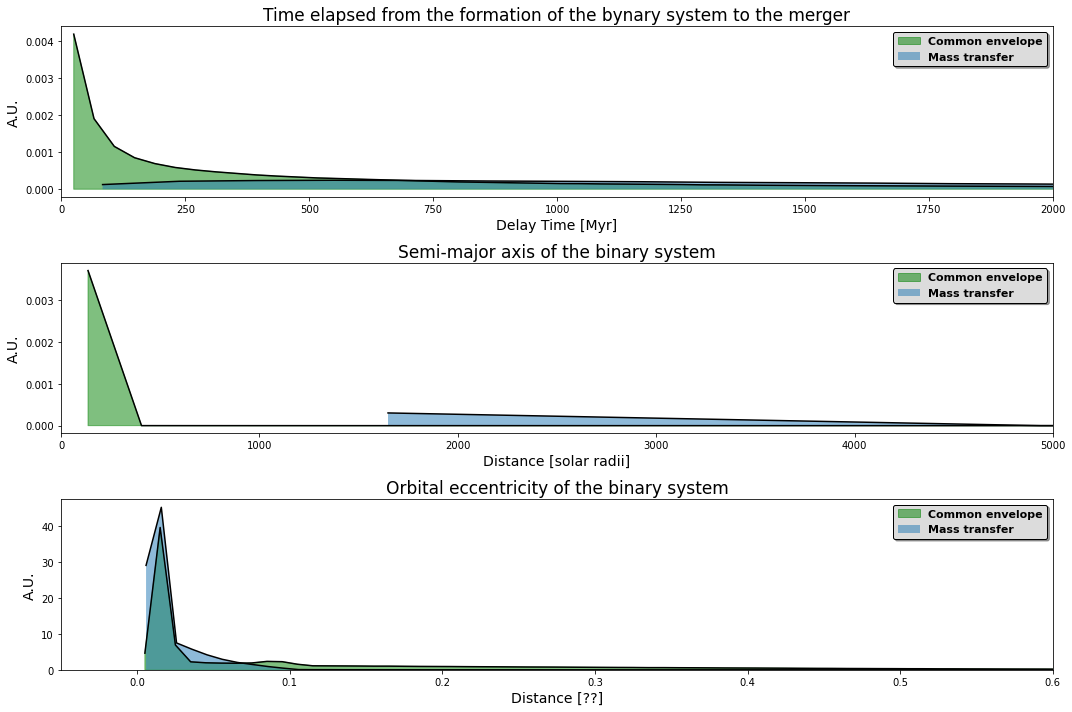

In [13]:
fig, ax = plt.subplots(nrows= 3, ncols=1, figsize=(15, 10))



#[0]  -   col.6:delay_time/Myr - col.21:CE   - Delay Time per Formation Process

entries_dt_t, edges_dt_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.6:delay_time/Myr'], bins = 'fd', color = 'w', density=True)
bin_centers_dt_t = 0.5 * (edges_dt_t[:-1] + edges_dt_t[1:])       #Norm Hist for TRUE - CommonEnvelope  

entries_dt_f, edges_dt_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.6:delay_time/Myr'], bins = 'fd', color = 'w', density=True)
bin_centers_dt_f = 0.5 * (edges_dt_f[:-1] + edges_dt_f[1:])       #Norm Hist for FALSE - StableMassTransfer

ax[0].plot(bin_centers_dt_t, entries_dt_t, color='black')
ax[0].fill_between(bin_centers_dt_t, entries_dt_t, alpha=0.5, color='green', label = 'Common envelope')

ax[0].plot(bin_centers_dt_f, entries_dt_f, color='black')
ax[0].fill_between(bin_centers_dt_f, entries_dt_f, alpha=0.5, label = 'Mass transfer')


ax[0].set_xlim(right=2000, left= -1)
ax[0].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[0].set_title('Time elapsed from the formation of the bynary system to the merger', fontsize=17)
ax[0].set_xlabel('Delay Time [Myr]', fontsize=14)
ax[0].set_ylabel('A.U.', fontsize=14)                 #legend & titles



#[1]  -   col.7:sma/Rsun - col.21:CE   - Semi-major axis of the binary system per Formation Process

entries_sma_t, edges_sma_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.7:sma/Rsun'], bins = 100, color = 'w', density=True)
bin_centers_sma_t = 0.5 * (edges_sma_t[:-1] + edges_sma_t[1:])      # Hist for TRUE - CommonEnvelope 

entries_sma_f, edges_sma_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.7:sma/Rsun'], bins = 100, color = 'w', density=True)
bin_centers_sma_f = 0.5 * (edges_sma_f[:-1] + edges_sma_f[1:])      #Hist for FALSE - StableMassTransfer

ax[1].plot(bin_centers_sma_t, entries_sma_t, color='black')
ax[1].fill_between(bin_centers_sma_t, entries_sma_t, alpha=0.5, color='green', label = 'Common envelope')

ax[1].plot(bin_centers_sma_f, entries_sma_f, color='black')
ax[1].fill_between(bin_centers_sma_f, entries_sma_f, alpha=0.5, label = 'Mass transfer')

ax[1].set_xlim(left= -1, right = 5000)

ax[1].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[1].set_title('Semi-major axis of the binary system', fontsize=17)
ax[1].set_xlabel('Distance [solar radii]', fontsize=14)
ax[1].set_ylabel('A.U.', fontsize=14)             #legend & titles



#[2]  -   col.8:ecc - col.21:CE   - Orbital eccentricity of the binary system vs Formation Process

entries_ecc_t, edges_ecc_t, _ = plt.hist(frame[frame['col.21:CE']==True]['col.8:ecc'], bins = 100, color = 'w', density=True)
bin_centers_ecc_t = 0.5 * (edges_ecc_t[:-1] + edges_ecc_t[1:])      # Norm Hist for TRUE - CommonEnvelope 

entries_ecc_f, edges_ecc_f, _ = plt.hist(frame[frame['col.21:CE']==False]['col.8:ecc'], bins = 100, color = 'w', density=True)
bin_centers_ecc_f = 0.5 * (edges_ecc_f[:-1] + edges_ecc_f[1:])      #Norm Hist for FALSE - StableMassTransfer

ax[2].plot(bin_centers_ecc_t, entries_ecc_t, color='black')
ax[2].fill_between(bin_centers_ecc_t, entries_ecc_t, alpha=0.5, color='green', label = 'Common envelope')

ax[2].plot(bin_centers_ecc_f, entries_ecc_f, color='black')
ax[2].fill_between(bin_centers_ecc_f, entries_ecc_f, alpha=0.5, label = 'Mass transfer')


ax[2].set_xlim(right=0.6, left= -0.05)
ax[2].legend(prop={'weight':'bold','size':11}, loc='upper right', facecolor='gainsboro', edgecolor='black', shadow=True)
ax[2].set_title('Orbital eccentricity of the binary system', fontsize=17)
ax[2].set_xlabel('Distance [??]', fontsize=14)
ax[2].set_ylabel('A.U.', fontsize=14)             #legend & titles


fig.tight_layout()